https://static.developer.riotgames.com/docs/lol/queues.json
rankUrl 에서 솔로랭크의 queue id는 420이다.

In [1]:
import pandas as pd
import requests
from urllib import parse
import numpy as np

In [45]:
apiKey = 'RGAPI-a1fd8724-b6cd-461e-ad4a-bccce834889a'
username = 'hideonbush' # 유저아이디
# champ = 'Udyr' # 원하는 챔프(머신러닝결과값)

id = parse.quote(username) # 아이디를 URL 인코딩

url = 'https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/' + id +'?api_key=' + apiKey #puuid값을 가져오기 위한 주소
r = requests.get(url)
r = r.json()
puuid = r['puuid'] # 해당 유저의 puuid 값 가져오기
encryptedSummonerId = r['id']

profileUrl = 'https://kr.api.riotgames.com/lol/league/v4/entries/by-summoner/'+ encryptedSummonerId +'?api_key=' + apiKey
r = requests.get(profileUrl)
r = r.json()
if len(r) == 1:
    wins = r[0]['wins'] 
    losses = r[0]['losses']
else:
    wins = r[1]['wins']    # 자유랭크 정보가 있으면 r[1]['wins']
    losses = r[1]['losses']    # 자유랭크 정보가 있으면 r[1]['losses']

# 랭크 n경기 매치아이디 가져오기, 100개가 최대, 100개 이상의 매치데이터는 없는듯
n = str(wins + losses)
if int(n) > 100:
    n = '100'

rankUrl = 'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/' + puuid + '/ids?queue=420&type=ranked&start=0&count='+n+'&api_key='+ apiKey
r = requests.get(rankUrl)
r = r.json()

rankId = r
print(rankId)

['KR_6478591086', 'KR_6478550592', 'KR_6478502424', 'KR_6478446067', 'KR_6477307825', 'KR_6477287801', 'KR_6477262770', 'KR_6477241207', 'KR_6477185006', 'KR_6476454641', 'KR_6476436235', 'KR_6476062948', 'KR_6476032088', 'KR_6475983635', 'KR_6475934659', 'KR_6475532958', 'KR_6475085986', 'KR_6475036765', 'KR_6474979839', 'KR_6474950411', 'KR_6474903767', 'KR_6474541894', 'KR_6474517747', 'KR_6474481896', 'KR_6474403700', 'KR_6474333924', 'KR_6474288215', 'KR_6472787620', 'KR_6472759377', 'KR_6472721841', 'KR_6472673716', 'KR_6472598768', 'KR_6472479955', 'KR_6472423215', 'KR_6470838790', 'KR_6470793589', 'KR_6470735141', 'KR_6470675892', 'KR_6470628461', 'KR_6470600432', 'KR_6470523374', 'KR_6470429971', 'KR_6469279544', 'KR_6469252175', 'KR_6469210308', 'KR_6469162536', 'KR_6469103623', 'KR_6468062041', 'KR_6468042003', 'KR_6468017710', 'KR_6467985785', 'KR_6467954376', 'KR_6467921315', 'KR_6467868585', 'KR_6467829415', 'KR_6467606220', 'KR_6467536321', 'KR_6467468342', 'KR_646740762

In [46]:
def getLatestDDragon():
    ver_url = "https://ddragon.leagueoflegends.com/api/versions.json"
    r = requests.get(ver_url)
    r = r.json()
    version = r[0]

    cham_url = 'https://ddragon.leagueoflegends.com/cdn/'+version+'/data/en_US/champion.json'
    r = requests.get(cham_url)
    r = r.json()
    champion = r['data']
    return champion

# 챔피언 id를 이름으로
def getChampionByKey(key):
    champion = getLatestDDragon()
    for championName in champion:   
        if champion[championName]["key"] == str(key):
            return championName

In [47]:
cham_mastery_url = 'https://kr.api.riotgames.com/lol/champion-mastery/v4/champion-masteries/by-summoner/'+ encryptedSummonerId +'?api_key=' + apiKey
r = requests.get(cham_mastery_url)
r = r.json()
championLevel = []  #챔피언 숙련도 레벨
championPoints = []  #챔피언 숙련도

mastered_champion_name = []


for c in r:
    mastered_champion_name.append(getChampionByKey(c['championId']))
    championLevel.append(c['championLevel'])
    championPoints.append(c['championPoints'])

cham_mastery_df = pd.DataFrame({'champion' : mastered_champion_name,
                   'championPoints' : championPoints,
                   'championLevel' : championLevel,
                  })

In [48]:
cham_mastery_df.head()

,champion,championPoints,championLevel
0,Leblanc,517167,7
1,Azir,283779,7
2,Syndra,261655,7
3,Zoe,256439,7
4,Irelia,243791,5


In [50]:
win = []
assists = []
deaths = []
kills = []
cham = []
for i in rankId:
    url = 'https://asia.api.riotgames.com/lol/match/v5/matches/' + i + '?api_key=' + apiKey
    r = requests.get(url)
    r = r.json()
#     print(r)
#     break
    info = r['info']  # 전체 데이터에서 info를 추출
    part = info['participants'] # info 데이터에서 유저들의 정보 추출
    for j in range(0,10): # 총 10명의 유저중 내가 원하는 puuid값을 가진 유저를 추출
        if part[j]['puuid'] == puuid:
#             if part[j]['championName'] == champ: # 유저가 champ를 플레이했던 매치데이터를 추출
            assists.append(part[j]['assists'])
            cham.append(part[j]['championName'])
            win.append(part[j]['win'])
            deaths.append(part[j]['deaths'])
            kills.append(part[j]['kills'])
                # 승리, 킬뎃값 넣어주기
print(cham)
print(win)
print(deaths)
print(kills)

['Kennen', 'KSante', 'Nautilus', 'Leblanc', 'Ahri', 'Darius', 'Khazix', 'Azir', 'Nautilus', 'KogMaw', 'Ornn', 'Ornn', 'Fiora', 'Ahri', 'Lissandra', 'Tristana', 'Kennen', 'Nidalee', 'Yone', 'Azir', 'Rakan', 'Azir', 'Akshan', 'KSante', 'Akshan', 'Akshan', 'Ahri', 'Ahri', 'Ahri', 'Tristana', 'Thresh', 'Lissandra', 'Leblanc', 'Ornn', 'KSante', 'Sylas', 'Jayce', 'Ahri', 'Annie', 'Ahri', 'Kassadin', 'Ornn', 'Ahri', 'KSante', 'Tristana', 'Ahri', 'Blitzcrank', 'Leblanc', 'Ahri', 'Tristana', 'Zoe', 'Milio', 'Ahri', 'Tristana', 'KSante', 'Tristana', 'KSante', 'Tristana', 'Yone', 'Ahri', 'Leblanc', 'Leblanc', 'Lissandra', 'Yasuo', 'Syndra', 'Annie', 'Ahri', 'Tristana', 'Leblanc', 'Fizz', 'Ahri', 'Leblanc', 'Tristana', 'Viego', 'Sylas', 'Jayce', 'Tristana', 'Tristana', 'Ahri', 'KSante', 'Annie', 'Tristana', 'Akali', 'KSante', 'Leblanc', 'Ahri', 'Nidalee', 'Vi', 'Vi', 'Lissandra', 'Vex', 'Leblanc', 'Galio', 'Tristana', 'Rumble', 'Hecarim', 'KSante', 'Ahri', 'KSante', 'KSante']
[True, True, True, Tr

In [51]:
kda_df = pd.DataFrame({'champion' : cham,
                   'win' : win,
                   'kills' : kills,
                   'deaths' : deaths,
                   'assists' : assists
                  })
kda_df.head()

,champion,win,kills,deaths,assists
0,Kennen,True,10,3,6
1,KSante,True,3,2,4
2,Nautilus,True,0,2,13
3,Leblanc,True,2,4,3
4,Ahri,True,9,3,17


In [52]:
   
tmp_df = kda_df.loc[(kda_df['champion'] == cham[0])]
tmp_df

,champion,win,kills,deaths,assists
0,Kennen,True,10,3,6
16,Kennen,True,9,3,5


In [53]:
cham = list(set(cham))
SoloRank_df = pd.DataFrame(columns=['total_play','champion', 'win rate', 'kda'])

for i in range(len(cham)):    
    tmp_df = kda_df.loc[(kda_df['champion'] == cham[i])]
    win_rate = len(tmp_df.loc[tmp_df['win'] == True]) / len(tmp_df)    #승률
    win_rate = round(win_rate, 2)
    try:
        kda = float(tmp_df['kills'].sum() + tmp_df['assists'].sum()) / float(tmp_df['deaths'].sum())
        kda = round(kda, 2)
    except ZeroDivisionError:
        kda = 'perfect - no deaths'
    SoloRank_df.loc[len(SoloRank_df)] = [len(tmp_df), cham[i], win_rate, kda]

In [54]:
SoloRank_df = SoloRank_df.sort_values('total_play', ascending=False)
SoloRank_df = SoloRank_df.set_index(keys=['total_play'])

In [55]:
SoloRank_df.head()

,champion,win rate,kda
total_play,,,
17,Ahri,0.71,7.19
13,Tristana,0.31,1.9
11,KSante,0.64,2.14
9,Leblanc,0.44,2.46
4,Lissandra,0.50,2.75


In [56]:
SoloRank_df.where('Ahri' == SoloRank_df['champion']).head() # where을 쓰면 나머지 행까지 NaN으로 표시되면서 나타냄

,champion,win rate,kda
total_play,,,
17,Ahri,0.71,7.19
13,NaN,NaN,NaN
11,NaN,NaN,NaN
9,NaN,NaN,NaN
4,NaN,NaN,NaN


In [57]:
SoloRank_df[SoloRank_df['champion'] == 'Ahri']

,champion,win rate,kda
total_play,,,
17,Ahri,0.71,7.19


In [58]:
SoloRank_with_mastery_df = pd.merge(SoloRank_df, cham_mastery_df, left_on='champion', right_on='champion', how='left')

In [59]:
SoloRank_with_mastery_df.set_index(SoloRank_df.index)

,champion,win rate,kda,championPoints,championLevel
total_play,,,,,
17,Ahri,0.71,7.19,108265,7
13,Tristana,0.31,1.9,57936,7
11,KSante,0.64,2.14,24515,5
9,Leblanc,0.44,2.46,517167,7
4,Lissandra,0.50,2.75,41855,7
4,Ornn,0.50,1.83,11925,3
3,Akshan,0.67,1.21,13833,4
3,Azir,0.67,4.5,283779,7
3,Annie,0.67,4.71,20325,4


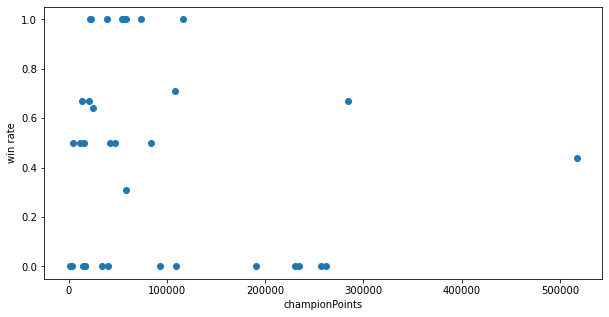

In [60]:
import matplotlib.pyplot as plt
import matplotlib

x = SoloRank_with_mastery_df['championPoints']
y = SoloRank_with_mastery_df['win rate']

plt.figure(figsize=(10, 5))
plt.xlabel("championPoints")
plt.ylabel("win rate")
plt.scatter(x, y)
plt.show()

x 좌표의 값의 범위가 너무 넓다. 표준화 및 정규화를 하여 스케일링하자.

### 데이터 표준화
StandardScaler: 데이터를 표준 정규 분포로 변환하는 데 사용되는 변환기, 평균을 0, 분산을 1로 표준화

In [61]:
from sklearn.preprocessing import StandardScaler
x = np.array(x).reshape(-1, 1)
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)

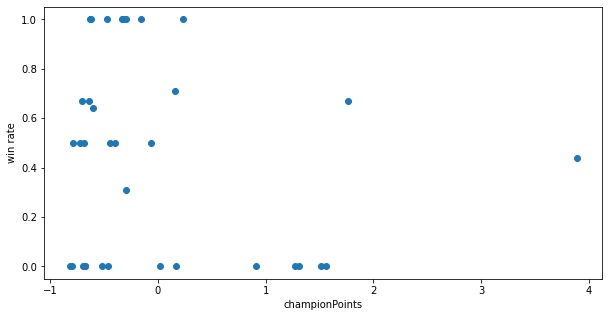

In [62]:
plt.figure(figsize=(10, 5))
plt.xlabel("championPoints")
plt.ylabel("win rate")
plt.scatter(scaled_x, y)
plt.show()

### 데이터 정규화
MinMaxScaler: 0~1 사이의 값으로 정규화

In [63]:
from sklearn.preprocessing import MinMaxScaler
x = np.array(x).reshape(-1, 1)
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x)

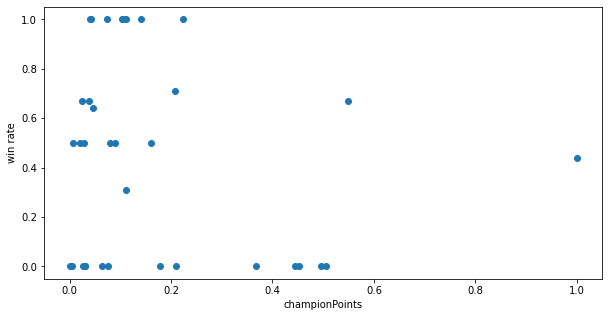

In [64]:
plt.figure(figsize=(10, 5))
plt.xlabel("championPoints")
plt.ylabel("win rate")
plt.scatter(scaled_x, y)
plt.show()

### 히트맵 그리기

<AxesSubplot:>

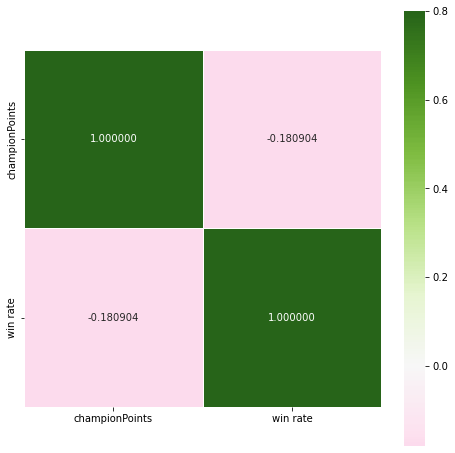

In [65]:
import seaborn as sns
corrmat = SoloRank_with_mastery_df[['championPoints', 'win rate']].corr()
sns.color_palette("Paired")
plt.figure(figsize = (8,8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="PiYG", center=0, 
            annot=True, fmt='f', linewidths=.5)

<AxesSubplot:>

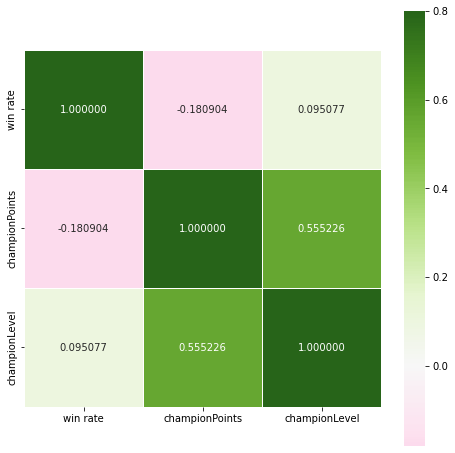

In [66]:
corrmat = SoloRank_with_mastery_df.corr()
sns.color_palette("Paired")
plt.figure(figsize = (8,8))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="PiYG", center=0, 
            annot=True, fmt='f', linewidths=.5)